In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline
import glob
import os
import scipy as sp

Populating the interactive namespace from numpy and matplotlib


### Activate environment

`source activate ATACseq_clustering`

In [67]:
#Import Gene Score Matrix
df_matrix = pd.read_csv('/PHShome/ta779/2019_03_scATAC/script_to_submit/pbmc/data/FM_GeneScoring_10xpbmc.tsv',sep="\t")

In [68]:
#Define a function to compute the Gini score
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area


In [69]:
df_matrix.head()

,Unnamed: 0,AAACGAAAGCGCAATG-1,AAACGAAAGGGTATCG-1,AAACGAAAGTAACATG-1,AAACGAAAGTTACACC-1,AAACGAACAGAGATGC-1,AAACGAACATGCTATG-1,AAACGAAGTGCATCAT-1,AAACGAAGTGGACGAT-1,AAACGAAGTGGCCTCA-1,...,TTTGGTTGTCAGAAAT-1,TTTGGTTGTTGTATCG-1,TTTGGTTTCAGTGGTT-1,TTTGTGTAGGAAACTT-1,TTTGTGTCAAGCCTTA-1,TTTGTGTCACTCAAGT-1,TTTGTGTCACTGGGCT-1,TTTGTGTGTACGCAAG-1,TTTGTGTGTCTGCGCA-1,TTTGTGTTCAACTTGG-1
0,A1BG,0.256244,5.239293,8.794614,0.685562,0.048870,0.012939,0.002157,0.261534,0.001554,...,0.155907,7.394677,1.913891,0.046714,9.268239,0.002675,6.810591,7.418139,3.471564,1.730391
1,A1BG-AS1,1.366762,1.359241,2.722776,3.228675,0.053614,0.069121,0.011907,1.398078,0.000291,...,0.032595,4.054271,1.412822,0.043060,5.445530,0.012003,9.144693,3.197848,0.923244,0.432918
2,A2LD1,0.000363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,A2M,0.000000,0.056803,0.002662,0.000000,5.514523,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.014432,15.971836,0.000000,0.004094,0.000000,0.001638,0.001331,0.000000,0.000000
4,A2M-AS1,0.000000,0.052984,0.002483,0.000000,5.143764,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.013462,14.897999,0.000000,0.003819,0.000000,0.001527,0.001241,0.000000,0.000000


In [70]:
#Parse the Table renaming the first column
df_matrix.columns=['Gene']+list(df_matrix.columns[1:].values)
df_matrix.set_index('Gene',inplace=True)
df_matrix.head()

In [76]:
#https://www.tau.ac.il/~elieis/Housekeeping_genes.html

housekeeping_genes=[
    'ACTB',
    'ALDOA',
    'GAPDH','PGK1','LDHA','RPS27A','RPL19','RPL11','NONO','ARHGDIA','RPL32','RPS18','HSPCB',
        
    'C1orf43',
'CHMP2A',
'EMC7',
'GPI',
'PSMB2,'
'PSMB4',
'RAB7A',
'REEP5',
'SNRPD3',
'VCP',
'VPS29']

In [77]:
housekeeping_genes=list(map(str.strip,housekeeping_genes))

In [78]:
marker_genes=['CD209', 'ENG', 'FOXP3', 'CD34', 'BATF3', 'S100A12', 'THBD',
       'CD3D', 'THY1', 'CD8A', 'CD8B', 'CD14', 'PROM1', 'IL2RA', 'FCGR3A',
       'IL3RA', 'FCGR1A', 'CD19', 'IL7R', 'CD79A', 'MS4A1', 'NCAM1',
       'CD3E', 'CD3G', 'KIT', 'CD1C', 'CD68', 'CD4']

In [79]:
#Subset from the main matrix the housekeeping genes and test if successfull
df_matrix_housekeeping=df_matrix.loc[df_matrix.index.intersection(housekeeping_genes)]
df_matrix_housekeeping

In [81]:
#Subset from the main matrix the marker genes and test if successfull
df_matrix_marker=df_matrix.loc[df_matrix.index.intersection(marker_genes)]
df_matrix_marker

In [83]:
#Test gini function if works
gini(np.array([0.0,0,0,0,0,0,0,0,0,0,0,0,0,1])) 

0.9285714285714286

In [85]:
#Example of one clustering solution from SnapATAC using hierarchical clustering
clustering_filename='/PHShome/ta779/2019_03_scATAC/script_to_submit/pbmc/data/clustering_solutions/SnapATAC_clusters_hc.csv'

In [86]:
#Import the clustering file
clustering_info=pd.read_csv(clustering_filename)

clustering_method=set(clustering_info.columns.values)
clustering_method.discard('Barcode')
clustering_method=clustering_method.pop()

clustering_info=clustering_info.set_index(clustering_method)

In [88]:
#REMOVE CLUSTERS WITH FEW CELLS
min_cells_per_cluster=10

cluster_sizes=pd.value_counts(clustering_info.index)
print(cluster_sizes)

clustering_info=clustering_info.loc[cluster_sizes[cluster_sizes>min_cells_per_cluster].index.values,:]

0    2218
2    1538
6     539
1     367
7     256
3     238
4     151
5      27
Name: hc, dtype: int64


In [89]:
clustering_info.head()

,Barcode
hc,
0,AAACGAAAGCGCAATG-1
0,AAACGAAAGGGTATCG-1
0,AAACGAACAGAGATGC-1
0,AAACGAACATGCTATG-1
0,AAACGAAGTGCATCAT-1


In [90]:
!head /PHShome/ta779/2019_03_scATAC/script_to_submit/pbmc/data/clustering_solutions/SnapATAC_clusters_hc.csv

Barcode,hc
AAACGAAAGCGCAATG-1,0
AAACGAAAGGGTATCG-1,0
AAACGAAAGTAACATG-1,6
AAACGAAAGTTACACC-1,6
AAACGAACAGAGATGC-1,0
AAACGAACATGCTATG-1,0
AAACGAAGTGCATCAT-1,0
AAACGAAGTGGACGAT-1,0
AAACGAAGTGGCCTCA-1,0


In [121]:
clustering_info_permuted=clustering_info.copy()
clustering_info_permuted.head()

,Barcode
hc,
0,AAACGAAAGCGCAATG-1
0,AAACGAAAGGGTATCG-1
0,AAACGAACAGAGATGC-1
0,AAACGAACATGCTATG-1
0,AAACGAAGTGCATCAT-1


,Barcode
hc,
0,AAACGAAAGCGCAATG-1
0,AAACGAAAGGGTATCG-1
0,AAACGAACAGAGATGC-1
0,AAACGAACATGCTATG-1
0,AAACGAAGTGCATCAT-1


In [93]:
#Test permutation
np.random.shuffle(clustering_info_permuted.values)
clustering_info_permuted.head()

/data/pinello/SHARED_SOFTWARE/anaconda3/envs/lab_ML/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/data/pinello/SHARED_SOFTWARE/anaconda3/envs/lab_ML/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


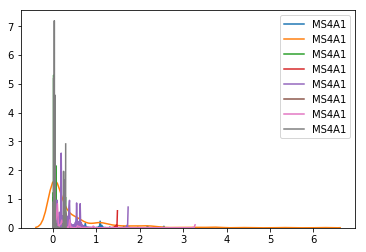

In [96]:
#Check for a marker gene the accessibility value distributoin across clusters
for idx_cluster in sorted(np.unique(clustering_info.index.values)):
    #print(clustering_info.loc[idx_cluster,:].values.flatten())
    sns.kdeplot(df_matrix.loc['MS4A1',clustering_info.loc[idx_cluster,:].values.flatten()])

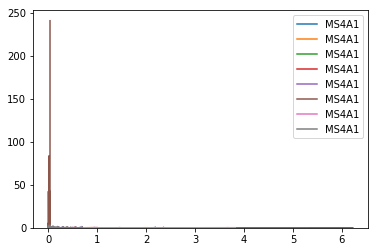

In [97]:
#Check for a marker gene the accessibility value distributoin across clusters using permuted clusters
for idx_cluster in sorted(np.unique(clustering_info.index.values)):
    sns.kdeplot(df_matrix.loc['MS4A1',clustering_info_permuted.loc[idx_cluster,:].values.flatten()])

In [98]:
sorted(clustering_info.index.unique())

[0, 1, 2, 3, 4, 5, 6, 7]

In [99]:
#Function to compute the average accessibility value per cluster
def get_avg_per_cluster(df_matrix, gene_name, clustering_info,use_log2=False):
    N_clusters=len(clustering_info.index.unique())
    avg_per_cluster=np.zeros(N_clusters)
    for idx,idx_cluster in enumerate(sorted(np.unique(clustering_info.index.unique()))):
        if use_log2:
            values_cluster=df_matrix.loc[gene_name,clustering_info.loc[idx_cluster,:].values.flatten()].apply(lambda x:np.log2(x+1))
        else:
            values_cluster=df_matrix.loc[gene_name,clustering_info.loc[idx_cluster,:].values.flatten()]
        
        avg_per_cluster[idx]=values_cluster.mean()
        if avg_per_cluster[idx]>0:
              avg_per_cluster[idx]=avg_per_cluster[idx]#/values_cluster.std()

    return avg_per_cluster
    

Text(0.5,1,'MS4A1 gini:0.7732191359130405')

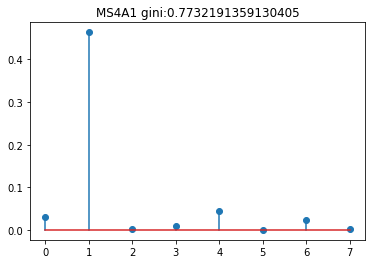

In [100]:
#Plot the average accessibility valye for 1 marker gene across different clusters
gene_name='MS4A1'
avg_per_cluster=get_avg_per_cluster(df_matrix, gene_name, clustering_info,use_log2=False)
plt.stem(avg_per_cluster)
plt.title(gene_name+ ' gini:'+str(gini(avg_per_cluster)))

Text(0.5,1,'GAPDH gini:0.28526832746965186')

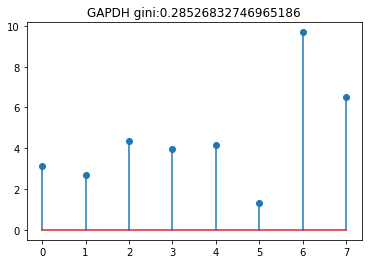

In [119]:
#Plot the average accessibility valye for 1 Housekeeping gene across different clusters

gene_name='GAPDH'
avg_per_cluster=get_avg_per_cluster(df_matrix, gene_name, clustering_info,use_log2=False)
plt.stem(avg_per_cluster)
plt.title(gene_name+ ' gini:'+str(gini(avg_per_cluster)))

In [120]:
gini(avg_per_cluster)

0.28526832746965186

In [103]:
#Test Perform permutation 
clustering_info_permuted=clustering_info.copy()
np.random.shuffle(clustering_info_permuted.values)

In [104]:
#Function to calculate Gini value for all the genes
def calculate_gini(df_matrix, gene_name,clustering_info):

    return gini(get_avg_per_cluster(df_matrix,gene_name,clustering_info,use_log2=False))

In [105]:
#Function to calculate Gini value for all the genes

def calculate_gini_values(df_matrix,clustering_info):
    gini_values=[]
    for gene_name in df_matrix.index:
        gini_values.append(calculate_gini(df_matrix, gene_name,clustering_info))
    
    return gini_values
        
        

In [106]:
#Compute Gini for Housekeeping genes
gini_values_housekeeping=calculate_gini_values(df_matrix_housekeeping,clustering_info)

In [107]:
len(gini_values_housekeeping)

21

In [108]:
#Compute Gini for Marker genes
gini_values_marker=calculate_gini_values(df_matrix_marker,clustering_info)

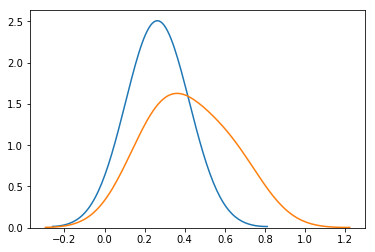

In [109]:
#Check whether average Gini of all the Marker Genes shif compared the average of the Housekeeping genes
sns.kdeplot(gini_values_housekeeping,bw=0.15)
sns.kdeplot(gini_values_marker,bw=0.15)

In [110]:
#Permute husekeeping genes
gini_values_housekeeping_shuffle=calculate_gini_values(df_matrix_housekeeping,clustering_info_permuted)

In [111]:
#Permute marker genes
gini_values_marker_shuffle=calculate_gini_values(df_matrix_marker,clustering_info_permuted)

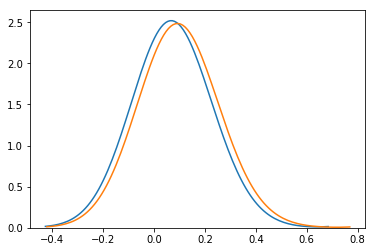

In [112]:
#Check if the simulated distributions overlap (if not we cannot conclude that the previous plot is conclusive)
sns.kdeplot(gini_values_housekeeping_shuffle,bw=0.15)
sns.kdeplot(gini_values_marker_shuffle,bw=0.15)

In [113]:
#Perform  Kolmogorov Smirnov statistic real
sp.stats.ks_2samp(gini_values_marker,gini_values_housekeeping)

Ks_2sampResult(statistic=0.5714285714285714, pvalue=0.0003916094683673321)

In [114]:
#Perform  Kolmogorov Smirnov statistic shuffled
sp.stats.ks_2samp(gini_values_marker_shuffle,gini_values_housekeeping_shuffle)

Ks_2sampResult(statistic=0.39285714285714285, pvalue=0.0353455425287002)

In [115]:
#Write a function to compute delta difference of the average accessibility in Marker vs Housekeeping and Kolmogorov Smirnov test
def score_clustering_solution(df_matrix_marker,df_matrix_housekeeping,clustering_info):
    gini_values_housekeeping=calculate_gini_values(df_matrix_housekeeping,clustering_info)
    gini_values_marker=calculate_gini_values(df_matrix_marker,clustering_info)
    statistic,p_value=sp.stats.ks_2samp(gini_values_marker,gini_values_housekeeping)
    
    return  np.mean(gini_values_marker), np.mean(gini_values_housekeeping),np.mean(gini_values_marker)-np.mean(gini_values_housekeeping), statistic,p_value
    

In [116]:
#Show result for one solution
score_clustering_solution(df_matrix_marker,df_matrix_housekeeping,clustering_info)

(0.41963106376965925,
 0.2650594261243363,
 0.15457163764532295,
 0.5714285714285714,
 0.0003916094683673321)

In [118]:
#Run the method for all the clustering solutions
min_cells_per_cluster=10
print('\t'.join(['Method','Clustering','Gini Marker Genes','Gini Housekeeping Genes','Difference','KS statistics','p-value']))
for clustering_filename in glob.glob('/PHShome/ta779/2019_03_scATAC/script_to_submit/pbmc/data/clustering_solutions/*csv'):
                                      
    #print(clustering_filename)
    
    
    #try:
        #load dataset
        clustering_info=pd.read_csv(clustering_filename)
        clustering_method=set(clustering_info.columns.values)
        clustering_method.discard('Barcode')
        clustering_method=clustering_method.pop()
        clustering_info=clustering_info.set_index(clustering_method)


        #REMOVE CLUSTERS WITH FEW CELLS
       
        cluster_sizes=pd.value_counts(clustering_info.index)
        clustering_info=clustering_info.loc[cluster_sizes[cluster_sizes>min_cells_per_cluster].index.values,:]


        mean_gini_marker,mean_gini_housekeeping,mean_gini_difference,statistics,p_value=score_clustering_solution(df_matrix_marker,df_matrix_housekeeping,clustering_info)
        
        #method,cluster_method=np.take(os.path.basename(clustering_filename).replace('.csv','').split('_'),[0,2])
        method,cluster_method=np.take(os.path.basename(clustering_filename).replace('.csv','').split('_'),[0,-1])
        
        print('\t'.join(map(str,[ method,cluster_method,mean_gini_marker,mean_gini_housekeeping,mean_gini_difference,statistics,p_value])))
       

       
    #except:
    #   print('Something wrong with: %s' % clustering_filename)
        
        
    
    
    
    
    
    
    

    

Method	Clustering	Gini Marker Genes	Gini Housekeeping Genes	Difference	KS statistics	p-value
SCRAT	hc	0.44397372785414885	0.46381341120217473	-0.019839683348025883	0.34523809523809523	0.08860195616485016
BROCKMAN	louvain	0.415771252340367	0.28836436969093565	0.12740688264943134	0.5714285714285714	0.0003916094683673321
chromVAR	louvain	0.2886946551925302	0.1989689743554142	0.08972568083711599	0.5	0.002897057550796698
chromVAR	louvain	0.3498265660302979	0.2518208704115438	0.09800569561875411	0.5	0.002897057550796698
chromVAR	louvain	0.3441607776205992	0.23145629116081567	0.11270448645978354	0.5357142857142857	0.0011012608985997434
chromVAR	louvain	0.34970055319086696	0.252163337680185	0.09753721551068195	0.5357142857142857	0.0011012608985997434
Cicero	louvain	0.31945719952393453	0.189562338924883	0.12989486059905153	0.5	0.002897057550796698
Cicero	louvain	0.5036086941033665	0.4278685576760916	0.0757401364272749	0.47619047619047616	0.005319945722709709
cisTopic	louvain	0.37568797350101446